In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor

C:\Users\Joheen\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

ymaster = pd.DataFrame()
xmaster = pd.DataFrame()

# Import data
def readadddata(filename):
    global xmaster
    global ymaster
    data = pd.read_csv(filename)
    data = data.drop(['Base'], 1)
    datetimes = data['Date/Time']
    dayofweek = []
    hour = []
    for s in datetimes:
        day = int(s.split('/')[1])%7
        dayofweek.append(day)
        time = int(s.split()[1].split(':')[0])*60+(int(s.split()[1].split(':')[1]))
        hour.append(time)
    data['dayofweek']=dayofweek
    data['hour']=hour
    df = data.drop(['Date/Time'], 1)
    y=df.drop('dayofweek', 1).drop('hour', 1)
    x=df.drop('Lat', 1).drop('Lon', 1)
    xmaster = pd.concat([xmaster, x])
    ymaster = pd.concat([ymaster, y])
    
readadddata('rides_data.csv')
readadddata('uber-raw-data-apr14.csv')
readadddata('uber-raw-data-aug14.csv')
readadddata('uber-raw-data-jul14.csv')
readadddata('uber-raw-data-jun14.csv')
readadddata('uber-raw-data-may14.csv')
ymaster.shape

(4534327, 2)

In [21]:
xtrain=xmaster[0:3600000]
ytrain=ymaster[0:3600000]
xtest=xmaster[3600000:4534327]
ytest=ymaster[3600000:4534327]
ytest.size

1868654

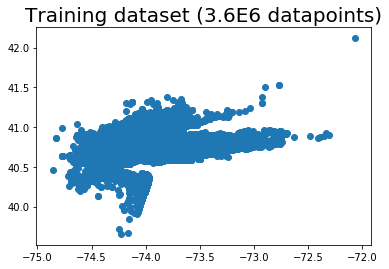

In [74]:
import matplotlib.pyplot as plt
plt.scatter(ytrain[['Lon']], ytrain[['Lat']])
plt.title("Training dataset (3.6E6 datapoints)", fontsize=20)
plt.show()

In [31]:
parameters = {'criterion': 'mse',
              'splitter': 'best',
              'max_depth': 6,
              'min_samples_split': 10,
              'min_samples_leaf': 3,
              'max_features': 'sqrt',
              'max_leaf_nodes': None}
RF_model = DecisionTreeRegressor(**parameters)
RF_model.fit(xtrain, ytrain)
RF_predictions = RF_model.predict(xtest)

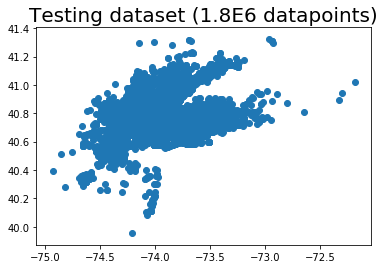

In [75]:
import matplotlib.pyplot as plt
plt.scatter(ytest[['Lon']], ytest[['Lat']])
plt.title("Testing dataset (1.8E6 datapoints)", fontsize=20)
plt.show()

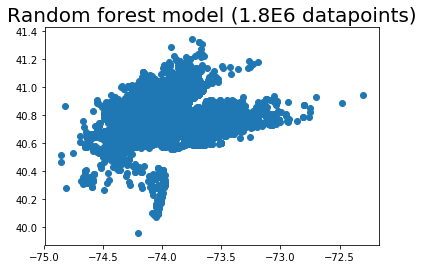

In [183]:
plt.scatter(RF_predictions[:,1], RF_predictions[:,0])
plt.title("Random forest model (1.8E6 datapoints)", fontsize=20)
plt.show()

In [37]:
#RANDOM FOREST REGRESSION SCORE: the average of the mean squared error of the latitude and the mean squared error of longitude
std = np.std(ytestmini.values[:,0])
# print(mean(RF_predictions[:,0])/mean(ytestmini.values[:,0]))

sigmalat = 0
c=0
for y in ytestmini.values[:,0]:
    sigmalat += (y-RF_predictions_mini[:,0][c])**2
    c += 1
mselat = (1/ytestmini.size)*(sigmalat)
print("Mean-squared-error, latitude: " + str(mselat))

sigmalon = 0
c=0
for y in ytestmini.values[:,1]:
    sigmalon += (y-RF_predictions_mini[:,1][c])**2
    c += 1
mselon = (1/ytestmini.size)*(sigmalon)
print("Mean-squared-error, longitude: " + str(mselon))

Mean-squared-error, latitude: 0.0008419197161084177
Mean-squared-error, longitude: 0.002735911888644866


In [127]:
import random

time = 648 #IN THE APP, THESE NUMBERS
day = 3    #ARE INPUTTED BY THE USER


xtimes = xmaster.loc[xmaster['hour']-time <= 5]
ytimes = ymaster.loc[xmaster['hour']-time <= 5] #gets all rides within 5 minutes
yrel = ytimes.loc[xtimes['dayofweek'] == day] #gets relevant x's

minlat = (ymaster['Lat'].values.min())
minlon = (ymaster['Lon'].values.min())
maxlat = (ymaster['Lat'].values.max())
maxlon = (ymaster['Lon'].values.max())

uniformgrid = []
latit = minlat
lonit = minlon
while lonit <= maxlon:
    while latit<=maxlat:
        zone = []
        zone.append(latit)
        zone.append(lonit)
        latit += .01449 #corresponds to 1 mile, latitude
        zone.append(latit)
        zone.append(lonit+.01455) #corresponds to 1 mile, longitude
        uniformgrid.append(zone)
    lonit += .01455
    latit=minlat
    
hotspots = np.zeros((170, 197)) #dimensions of uniformgrid

for index, row in yrel.iterrows():
    lat = row['Lat']
    lon = row['Lon']
    latbin = int((lat-minlat)/.01449)
    lonbin = int((lon-minlon)/.01455)
    
    hotspots[latbin][lonbin] += 1

    
finalout = []
for x in hotspots:
    for y in x:
        if y > hotspots.mean() + 5*hotspots.std():
            uWu = []
            uWu.append(y)
            uWu.append(uniformgrid[x.tolist().index(y)*170+hotspots.tolist().index(x.tolist())][0]+random.uniform(0,.01449)/2)
            uWu.append(uniformgrid[x.tolist().index(y)*170+hotspots.tolist().index(x.tolist())][1]+random.uniform(0,.01455)/2)
            finalout.append(uWu)
            
print(sorted(finalout,key=lambda x: x[0]))

[[864.0, 40.68598226884698, -74.18434375014039], [882.0, 40.70341769927766, -73.93384744489319], [984.0, 40.776412688166296, -73.87629136385497], [1042.0, 40.673852064465954, -73.99157695549562], [1042.0, 40.787869887861795, -73.96323137088817], [1149.0, 40.689685295578556, -73.97616532762437], [1212.0, 40.76046238900638, -73.86518426229445], [1261.0, 40.706990508319635, -73.99754726516116], [1320.0, 40.69264785719105, -73.96554600552666], [1361.0, 40.70416856697618, -74.02636029716848], [1374.0, 40.764345343877785, -73.94804844587806], [1395.0, 40.67322421531713, -73.96294886614204], [1450.0, 40.67623382205476, -73.97632803681672], [1583.0, 40.7437598165515, -73.96826822269533], [1806.0, 40.70386752891536, -73.95103572052273], [1875.0, 40.64563171605557, -73.78800975285571], [1883.0, 40.700803994185044, -73.96400959760538], [1932.0, 40.775831098419154, -73.99525730505489], [1953.0, 40.71970962874934, -73.95048064026972], [2302.0, 40.68598975794488, -73.99174340075861], [2622.0, 40.718

In [151]:
len(z)

170

C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


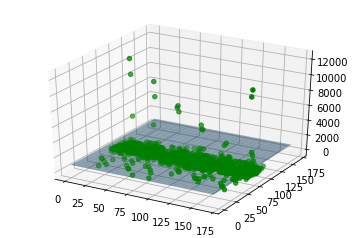

In [177]:
from mpl_toolkits.mplot3d import Axes3D
hotspots[hotspots == 0.0] = np.NaN
latbs = np.arange(0, 170, 1)
lonbs = np.arange(0, 197, 1)
latbs, lonbs = np.meshgrid(latbs, lonbs)

xx = np.arange(0, 170, 1)
yy = np.arange(0, 170, 1)
xx, yy = np.meshgrid(xx, yy)
z = np.full((170, 170), mean + 5*std)


plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(xx, yy, z, alpha=0.5)

# Ensure that the next plot doesn't overwrite the first plot
ax = plt.gca()
ax.hold(True)
ax.scatter(latbs, lonbs, hotspots, color='green')

plt.show()

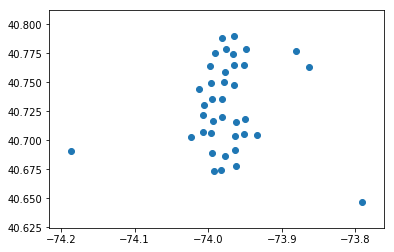

In [72]:
#HOTSPOTS GENERATED FOR 10:48 on Wednesday


lats = []
lons = []
for oWo in finalout:
    lats.append(oWo[1])
    lons.append(oWo[2])

plt.scatter(lons, lats)
plt.show()

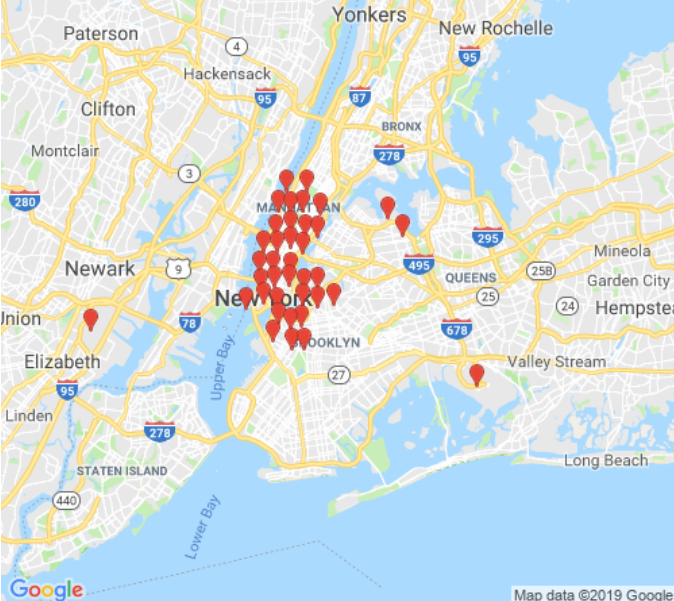

In [73]:
from IPython.display import Image
Image(filename='./samplemap.png')